In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import re
import gc

from PIL import Image
from sam2.sam2_video_predictor import SAM2VideoPredictor
from transformers import (
    AutoModelForCausalLM,
    AutoProcessor,
    GenerationConfig,
    BitsAndBytesConfig
)
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

/share/softwares/anaconda/anaconda3/envs/molmo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda'

In [ ]:
from utils.sam_utils import show_mask, show_box, show_points

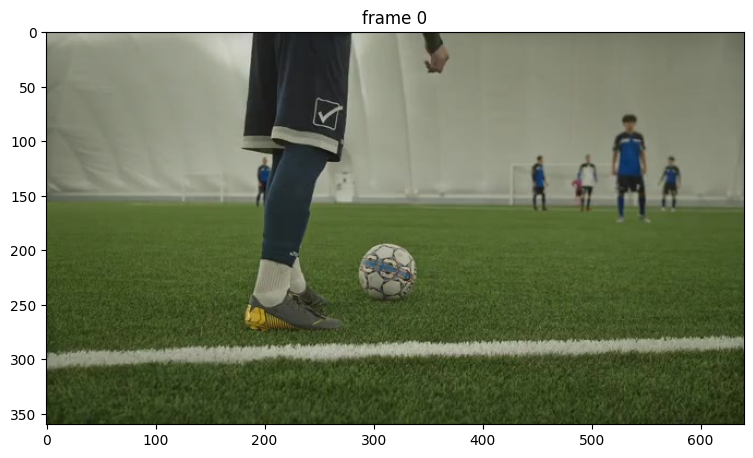

In [4]:
video_frames_dir = '/share/users/shehan/workspace_pointing_lmm/SAM_Molmo_Whisper/experiments/video_frames'

# Get frames and visualize the first one.
frame_names = [
    p for p in os.listdir(video_frames_dir)
    if os.path.splitext(p)[-1] in ['.jpg', '.jpeg', '.JPG', '.JPEG']
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_frames_dir, frame_names[frame_idx])))

In [7]:
# Load Molmo model and processor.
quant_config = BitsAndBytesConfig(
    load_in_4bit=True
)

# load the processor
processor = AutoProcessor.from_pretrained(
    'allenai/MolmoE-1B-0924',
    trust_remote_code=True,
    device_map='auto',
    torch_dtype='auto'
)

# load the model
model = AutoModelForCausalLM.from_pretrained(
    'allenai/MolmoE-1B-0924',
    trust_remote_code=True,
    offload_folder='offload',
    quantization_config=quant_config,
    torch_dtype='auto',
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPTNeoXTokenizer'. 
The class this function is called from is 'GPT2TokenizerFast'.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [5]:
def get_coords(output_string, image_path):
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    
    if 'points' in output_string:
        # Handle multiple coordinates
        matches = re.findall(r'(x\d+)="([\d.]+)" (y\d+)="([\d.]+)"', output_string)
        coordinates = [(int(float(x_val)/100*w), int(float(y_val)/100*h)) for _, x_val, _, y_val in matches]
    else:
        # Handle single coordinate
        match = re.search(r'x="([\d.]+)" y="([\d.]+)"', output_string)
        if match:
            coordinates = [(int(float(match.group(1))/100*w), int(float(match.group(2))/100*h))]
            
    return coordinates

In [6]:
def draw_point_and_show(image_path=None, points=None):
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    for point in points:
        image = cv2.circle(
            image, 
            (point[0], point[1]), 
            radius=5, 
            color=(0, 255, 0), 
            thickness=5,
            lineType=cv2.LINE_AA
        )

    plt.imshow(image[..., ::-1])
    plt.axis('off')
    plt.show()

In [ ]:

def run_molmo_inference(image_path=None, prompt='Describe this image.'):
    # process the image and text
    if image_path:
        inputs = processor.process(
            images=[Image.open(image_path)],
            text=prompt
        )
    else:
        inputs = processor.process(
            text=prompt
        )

    # move inputs to the correct device and make a batch of size 1
    inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

    # generate output; maximum 200 new tokens; stop generation when <|endoftext|> is generated
    output = model.generate_from_batch(
        inputs,
        GenerationConfig(max_new_tokens=200, stop_strings='<|endoftext|>'),
        tokenizer=processor.tokenizer
    )

    # only get generated tokens; decode them to text
    generated_tokens = output[0,inputs['input_ids'].size(1):]
    generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # print the generated text
    print(generated_text)
    return generated_text

In [9]:
# Pass the first frame to get the coordinates.
image_path = f'{video_frames_dir}/00000.jpg'

outputs = run_molmo_inference(image_path=image_path, prompt="Point to the main player's shoes")

 <points x1="31.7" y1="73.5" x2="38.5" y2="68.5" alt="main player's shoes">main player's shoes</points>


In [13]:
model

MolmoForCausalLM(
  (model): MolmoModel(
    (transformer): ModuleDict(
      (wte): Embedding()
      (emb_drop): Dropout(p=0.0, inplace=False)
      (ln_f): RMSLayerNorm()
      (blocks): ModuleList(
        (0-15): 16 x MolmoDecoderLayer(
          (attn): MolmoAttention(
            (rotary_emb): RotaryEmbedding()
            (q_norm): RMSLayerNorm()
            (k_norm): RMSLayerNorm()
            (act): SwiGLU()
            (att_proj): Linear4bit(in_features=2048, out_features=6144, bias=False)
            (attn_out): Linear4bit(in_features=2048, out_features=2048, bias=False)
            (attn_norm): RMSLayerNorm()
          )
          (mlp): MolmoeSparseMoeBlock(
            (gate): Linear4bit(in_features=2048, out_features=64, bias=False)
            (experts): ModuleList(
              (0-63): 64 x MolmoeMLP(
                (gate_proj): Linear4bit(in_features=2048, out_features=1024, bias=False)
                (up_proj): Linear4bit(in_features=2048, out_features=1024, bias

In [14]:
processor

MolmoProcessor:
- image_processor: MolmoImageProcessor {
  "auto_map": {
    "AutoImageProcessor": "allenai/MolmoE-1B-0924--image_preprocessing_molmo.MolmoImageProcessor",
    "AutoProcessor": "allenai/MolmoE-1B-0924--preprocessing_molmo.MolmoProcessor"
  },
  "base_image_input_size": [
    336,
    336
  ],
  "do_normalize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_padding_mask": true,
  "image_patch_size": 14,
  "image_processor_type": "MolmoImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "image_token_length_h": 12,
  "image_token_length_w": 12,
  "max_crops": 12,
  "overlap_margins": [
    4,
    4
  ],
  "processor_class": "MolmoProcessor"
}

- tokenizer: GPT2TokenizerFast(name_or_path='allenai/MolmoE-1B-0924', vocab_size=50280, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|endoftext|>', 'pad_token': '<|p